In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("claim_insurance_fraud.csv")D:\Kuliah\Semester 7\TA\Fraud_Insured_Automobile_Detection\data\

<>:6: SyntaxWarning: invalid escape sequence '\K'
<>:6: SyntaxWarning: invalid escape sequence '\K'
C:\Users\Wanda Azizah\AppData\Local\Temp\ipykernel_27716\4075997571.py:6: SyntaxWarning: invalid escape sequence '\K'
  df = pd.read_csv("D:\Kuliah\Semester 7\TA\Fraud_Insured_Automobile_Detection\data\claim_insurance_fraud.csv")


# new features

### Fitur days_since_policy

Mengukur jarak waktu antara polis aktif dan kejadian klaim.

In [10]:
# Konversi tanggal
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['days_since_policy'] = (df['incident_date'] - df['policy_bind_date']).dt.days

In [11]:
df[df['days_since_policy'] < 0]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,days_since_policy
578,415,52,794731,2015-02-22,IN,250/500,1000,973.5,0,468634,...,YES,51090,7860,7860,35370,Toyota,Highlander,2003,N,-20


In [12]:
df[df['days_since_policy'] < 0][['incident_date', 'policy_bind_date', 'days_since_policy']]

,incident_date,policy_bind_date,days_since_policy
578,2015-02-02,2015-02-22,-20


In [13]:
df[df['days_since_policy'] < 100][['incident_date', 'policy_bind_date', 'days_since_policy', 'fraud_reported']]

,incident_date,policy_bind_date,days_since_policy,fraud_reported
18,2015-01-19,2014-12-28,22,N
97,2015-01-22,2014-11-01,82,Y
209,2015-01-14,2014-12-10,35,N
355,2015-02-06,2014-12-13,55,N
578,2015-02-02,2015-02-22,-20,N
673,2015-01-20,2014-12-05,46,N
775,2015-01-23,2015-01-17,6,N
918,2015-02-19,2015-01-03,47,N


kemungkinan ini terjadi kesalahan pada penginputan data, karena Klaim sebelum polis aktif secara aturan tidak sah dan tidak mungkin terjadi. dan karena dia termasuk ke label non fraud jadi lebih baik di drop saja

In [14]:
# Hapus baris dengan days_since_policy < 0
initial_rows = df.shape[0]
df = df[df['days_since_policy'] >= 0].copy()
print(f"Dropped {initial_rows - df.shape[0]} rows with negative days_since_policy")

Dropped 1 rows with negative days_since_policy


### Fitur unknown_property_damage

Pada tahap feature engineering, nilai seperti ‘?’ tidak langsung dianggap sebagai missing, tetapi diperlakukan sebagai informasi eksplisit karena ketidakjelasan laporan itu sendiri berpotensi relevan terhadap fraud

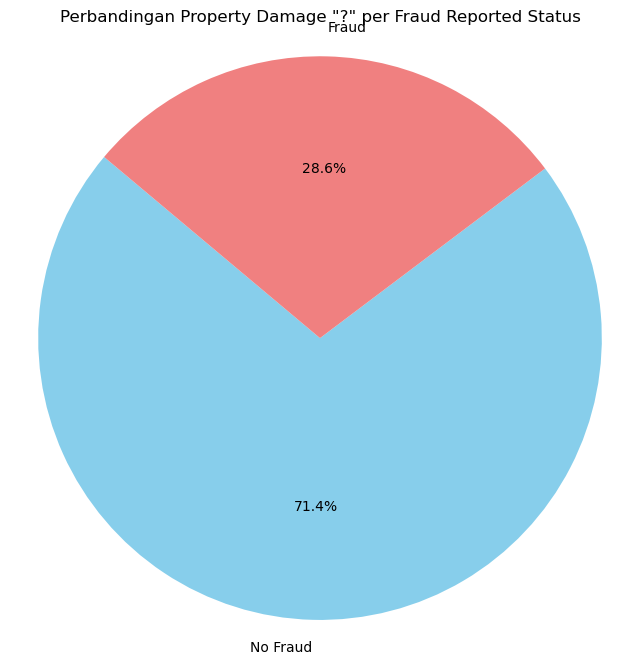

In [15]:
# Filter the DataFrame for rows where 'property_damage' is '?'
df_damage_yes = df[df['property_damage'] == '?']

# Group by 'fraud_reported' and count the occurrences
fraud_counts = df_damage_yes['fraud_reported'].value_counts()

fraud_counts = fraud_counts.reindex(['N', 'Y'])

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts,
        labels=['No Fraud', 'Fraud'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue', 'lightcoral'])
plt.title('Perbandingan Property Damage "?" per Fraud Reported Status')
plt.axis('equal')
plt.show()

In [16]:
df['unknown_property_damage'] = (df['property_damage'] == '?').astype(int)

In [17]:
df['unknown_property_damage'].value_counts()

unknown_property_damage
0    639
1    360
Name: count, dtype: int64

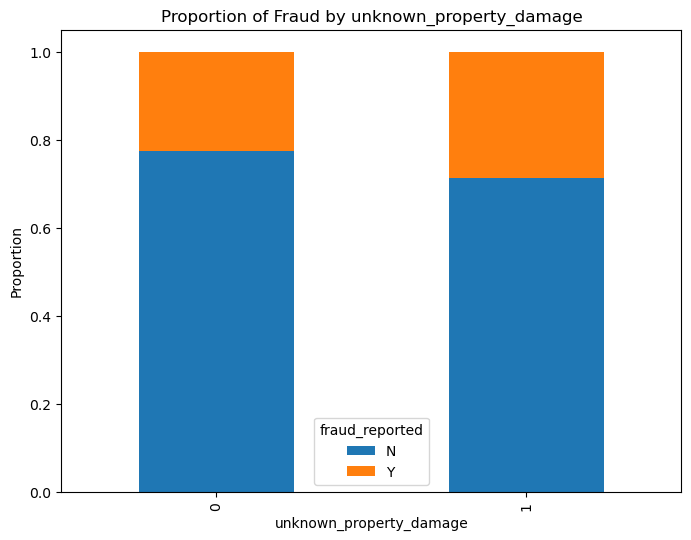

In [18]:
pd.crosstab(
    df['unknown_property_damage'],
    df['fraud_reported'],
    normalize='index'
).plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Proportion of Fraud by unknown_property_damage")
plt.ylabel("Proportion")
plt.show()


### fitur unknown_collision_type

In [19]:
df['unknown_collision_type'] = (df['collision_type'] == '?').astype(int)

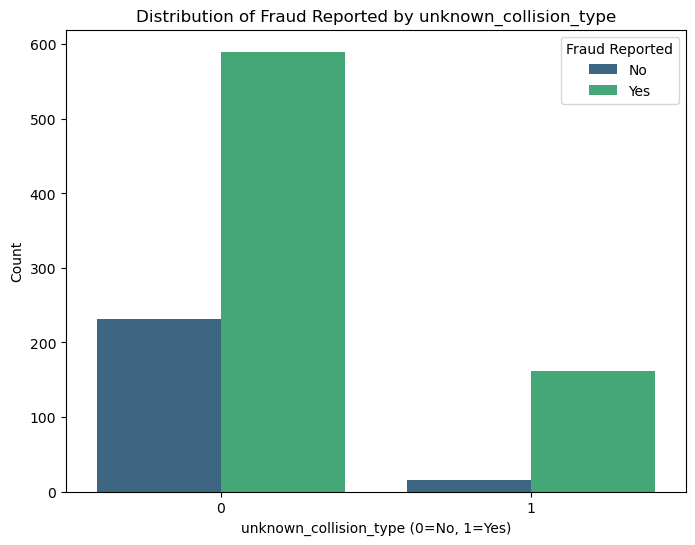

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='unknown_collision_type', hue='fraud_reported', data=df, palette='viridis')
plt.title('Distribution of Fraud Reported by unknown_collision_type')
plt.xlabel('unknown_collision_type (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Fraud Reported', labels=['No', 'Yes'])

plt.show()

In [21]:
df['unknown_collision_type'].value_counts()

unknown_collision_type
0    821
1    178
Name: count, dtype: int64

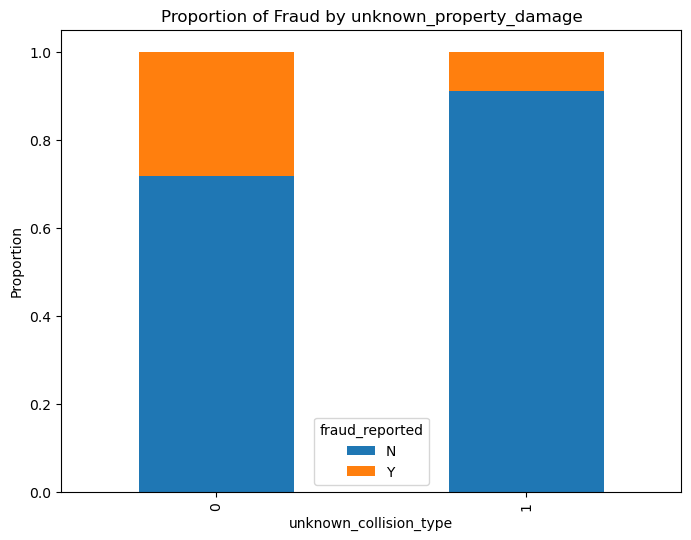

In [22]:
pd.crosstab(
    df['unknown_collision_type'],
    df['fraud_reported'],
    normalize='index'
).plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Proportion of Fraud by unknown_property_damage")
plt.ylabel("Proportion")
plt.show()


### Fitur unknown_police_report_but_severe_damage

In [23]:
# menambah fitur unknown_police_report_but_severe_damage
df['unknown_police_report_but_severe_damage'] = (
    (df['police_report_available'] == '?') &
    (df['incident_severity'].isin(['Major Damage', 'Total Loss']))
).astype(int)

karena ternyata kolom police report available yang nilainya '?' lebih banyak mengindikasikan bahwa dia termasuk fraud. maka dilakukakn fitur tambahan untuk nilai yang '?' agar informasi ini bisa dimanfaatkan oleh model

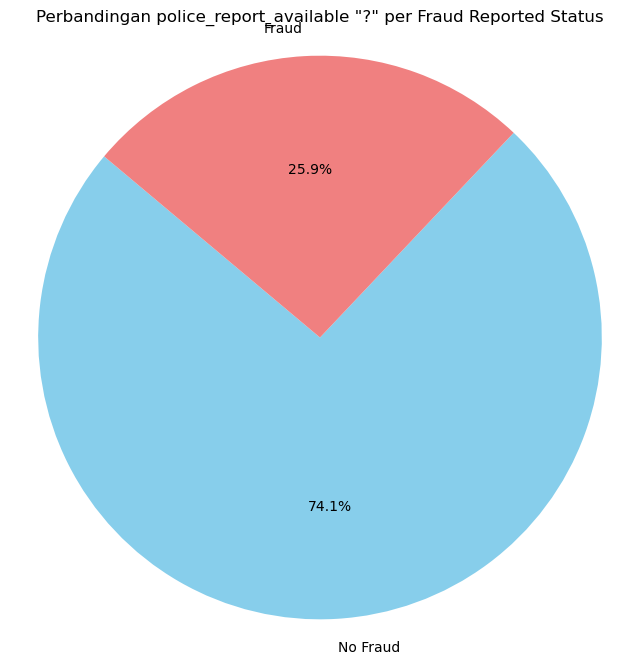

In [24]:
# Filter the DataFrame for rows where 'property_damage' is '?'
df_damage_yes = df[df['police_report_available'] == '?']

# Group by 'fraud_reported' and count the occurrences
fraud_counts = df_damage_yes['fraud_reported'].value_counts()

fraud_counts = fraud_counts.reindex(['N', 'Y'])

plt.figure(figsize=(8, 8))
plt.pie(fraud_counts,
        labels=['No Fraud', 'Fraud'],
        autopct='%1.1f%%',
        startangle=140,
        colors=['skyblue', 'lightcoral'])
plt.title('Perbandingan police_report_available "?" per Fraud Reported Status')
plt.axis('equal')
plt.show()

In [25]:
df['unknown_police_report_but_severe_damage'].value_counts()

unknown_police_report_but_severe_damage
0    803
1    196
Name: count, dtype: int64

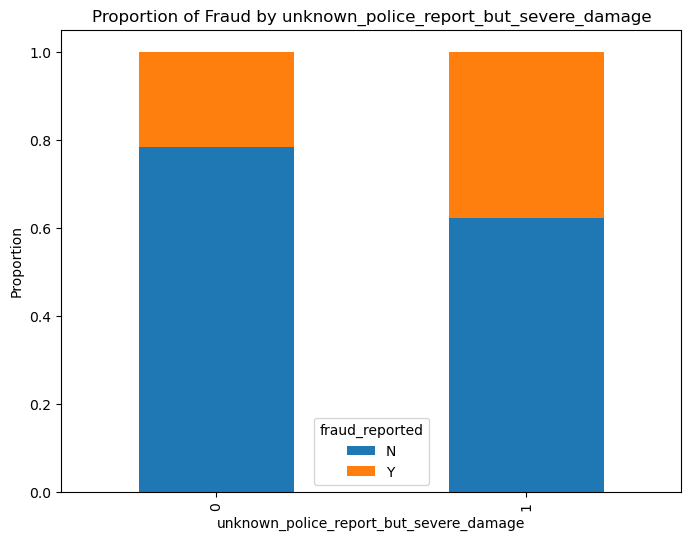

In [26]:
pd.crosstab(
    df['unknown_police_report_but_severe_damage'],
    df['fraud_reported'],
    normalize='index'
).plot(kind='bar', stacked=True, figsize=(8,6))
plt.title("Proportion of Fraud by unknown_police_report_but_severe_damage")
plt.ylabel("Proportion")
plt.show()


### fitur high_claim_without_witnesses

In [27]:
# menambahkan fitur high_claim_without_witnesses
df['high_claim_without_witnesses'] = ((df['total_claim_amount'] > df['total_claim_amount'].quantile(0.9)) &
                                      (df['witnesses'] == 0)).astype(int)

fitur ini untuk:
- klaim besar tanpa saksi bisa jadi red flag untuk kasus fraud karena biasanya penipu akan membuat klaim fiktif tanpa saksi agar tidak bisa diverfikasi

C:\Users\Wanda Azizah\AppData\Local\Temp\ipykernel_27716\352603725.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='high_claim_without_witnesses', data=df, palette='viridis')


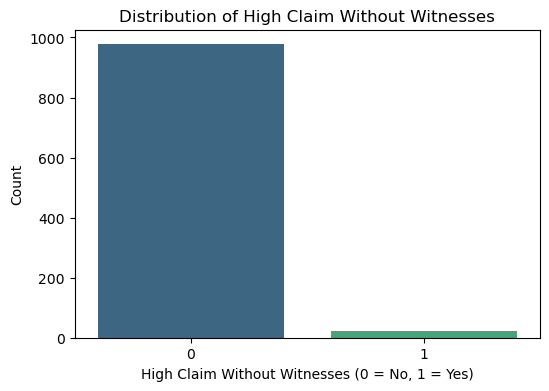

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x='high_claim_without_witnesses', data=df, palette='viridis')
plt.title('Distribution of High Claim Without Witnesses')
plt.xlabel('High Claim Without Witnesses (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

In [29]:
df[df['high_claim_without_witnesses'] == 1]

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,days_since_policy,unknown_property_damage,unknown_collision_type,unknown_police_report_but_severe_damage,high_claim_without_witnesses
94,271,42,307447,1990-03-17,IL,100/300,500,1515.30,0,603248,...,68160,Mercedes,ML350,2005,N,9074,0,0,0,1
104,350,54,939905,2013-10-31,OH,500/1000,500,1495.10,0,609374,...,70110,Chevrolet,Malibu,2014,N,469,0,0,1,1
149,193,41,217938,1995-07-16,OH,250/500,500,847.03,0,438555,...,77760,Suburu,Impreza,2011,Y,7147,1,0,0,1
150,134,32,203914,2001-06-09,OH,100/300,1000,1000.06,0,440961,...,60160,Audi,A3,2014,N,4962,1,0,1,1
163,112,30,346940,2002-09-13,OH,500/1000,1000,1166.54,0,479852,...,75530,Dodge,Neon,1997,Y,4513,0,0,0,1
164,122,34,985436,2003-08-09,IL,250/500,500,1495.06,0,452249,...,63630,Mercedes,E400,2011,N,4169,0,0,0,1
226,371,52,740505,1997-10-12,IL,250/500,1000,1242.96,7000000,449800,...,68400,Accura,RSX,2010,N,6342,0,0,0,1
270,369,55,577810,2013-04-15,OH,250/500,2000,1589.54,0,444734,...,59710,Toyota,Highlander,2003,N,652,1,0,0,1
314,91,30,515217,2010-06-18,IL,250/500,2000,1316.63,8000000,613178,...,58500,BMW,X6,2009,N,1665,0,0,0,1
419,138,33,296960,1997-01-18,IL,250/500,500,1362.87,5000000,445904,...,66330,BMW,X5,2007,N,6611,0,0,0,1


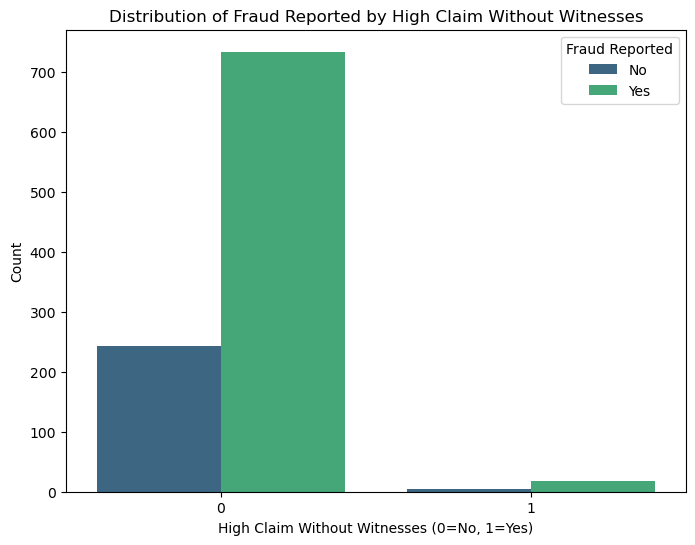

In [30]:
plt.figure(figsize=(8, 6))
sns.countplot(x='high_claim_without_witnesses', hue='fraud_reported', data=df, palette='viridis')
plt.title('Distribution of Fraud Reported by High Claim Without Witnesses')
plt.xlabel('High Claim Without Witnesses (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Fraud Reported', labels=['No', 'Yes'])
plt.show()

### Fitur multi_vehicles_no_injury

In [31]:
df['multi_vehicles_no_injury'] = ((df['number_of_vehicles_involved'] > 2) &
                                  (df['bodily_injuries'] == 0)).astype(int)

fitur ini untuk:
- Tabrakan multi-kendaraan tanpa cedera mencurigakan — biasanya pasti ada cedera ringan.
- Bisa jadi "tabrakan palsu" antar komplotan fraudster.

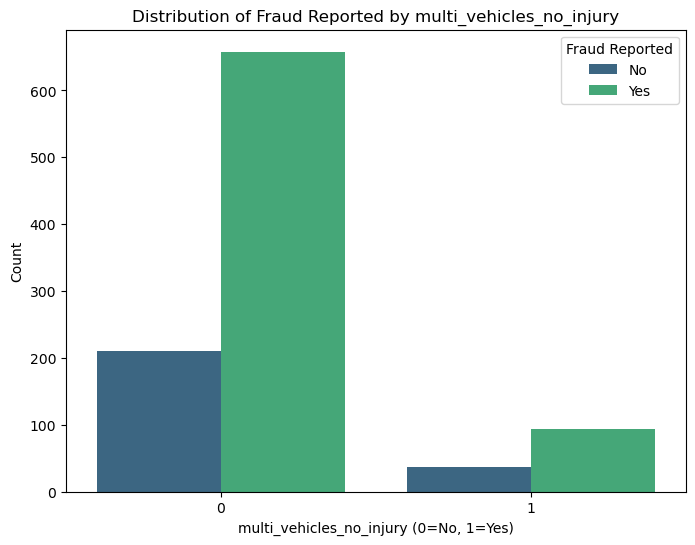

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='multi_vehicles_no_injury', hue='fraud_reported', data=df, palette='viridis')
plt.title('Distribution of Fraud Reported by multi_vehicles_no_injury')
plt.xlabel('multi_vehicles_no_injury (0=No, 1=Yes)')
plt.ylabel('Count')
plt.legend(title='Fraud Reported', labels=['No', 'Yes'])
plt.show()

### Fitur no_police_report_but_severe_damage

In [33]:
# menambah fitur no_police_report_but_severe_damage
df['no_police_report_but_severe_damage'] = ((df['police_report_available'] == 'NO') &
                                            (df['incident_severity'].isin(['Major Damage', 'Total Loss']))).astype(int)

fitur ini untuk:
- melihat apakah terdapat kecelakaan dengan kerusakan yang parah namun tidak melaporkannya ke polisi dan sering kali menjadi indikasi kecurangan

In [34]:
df['police_report_available'].unique()

array(['YES', '?', 'NO'], dtype=object)

C:\Users\Wanda Azizah\AppData\Local\Temp\ipykernel_27716\3217098525.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='no_police_report_but_severe_damage', data=df, palette='viridis')


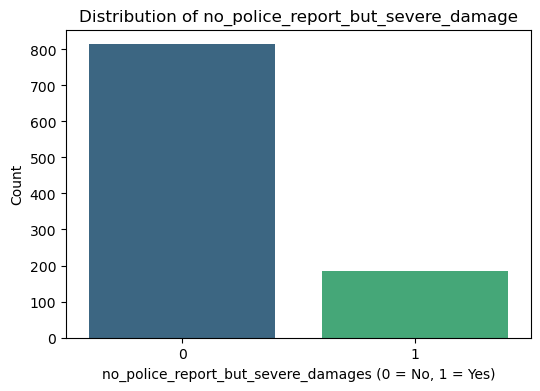

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='no_police_report_but_severe_damage', data=df, palette='viridis')
plt.title('Distribution of no_police_report_but_severe_damage')
plt.xlabel('no_police_report_but_severe_damages (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

### Fitur zip prefix

In [36]:
print("unique insured_zip :", df['insured_zip'].nunique())

df['zip_prefix'] = df['insured_zip'].astype(str).str[:3]
print("unique prefix 3 digit :", df['zip_prefix'].nunique())

print("\nvalue_counts insured_zip")
print(df['insured_zip'].value_counts().describe())

print("\nvalue_counts zip_prefix")
print(df['zip_prefix'].value_counts().describe())

# convert zip_prefix ke categorical
df['zip_prefix'] = df['zip_prefix'].astype('category')

unique insured_zip : 994
unique prefix 3 digit : 71

value_counts insured_zip
count    994.000000
mean       1.005030
std        0.070781
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: count, dtype: float64

value_counts zip_prefix
count    71.000000
mean     14.070423
std       3.423966
min       8.000000
25%      12.000000
50%      14.000000
75%      16.000000
max      22.000000
Name: count, dtype: float64


'zip_prefix' didapat dari 3 angka pertama dari 'insured_zip' dan ternyata berguna karena 3 angka tersebut punya 74 unik dimana masing masing prefixnya punya 8-22 sample, yang menunjukkan bisa jadi itu menentukan lokasi. jadi pakai zip_prefix dan buang insured_zip

### fitur auto_make_model

In [37]:
print('unique auto_make: ', df['auto_make'].nunique())
print('unique auto_model: ', df['auto_model'].nunique())

unique auto_make:  14
unique auto_model:  39


In [38]:
# Gabungkan fitur auto_make dan auto_brand
df['auto_make_model'] = df['auto_make'] + '_' + df['auto_model']

In [39]:
print('unique auto_make_model: ', df['auto_make_model'].nunique())

unique auto_make_model:  39


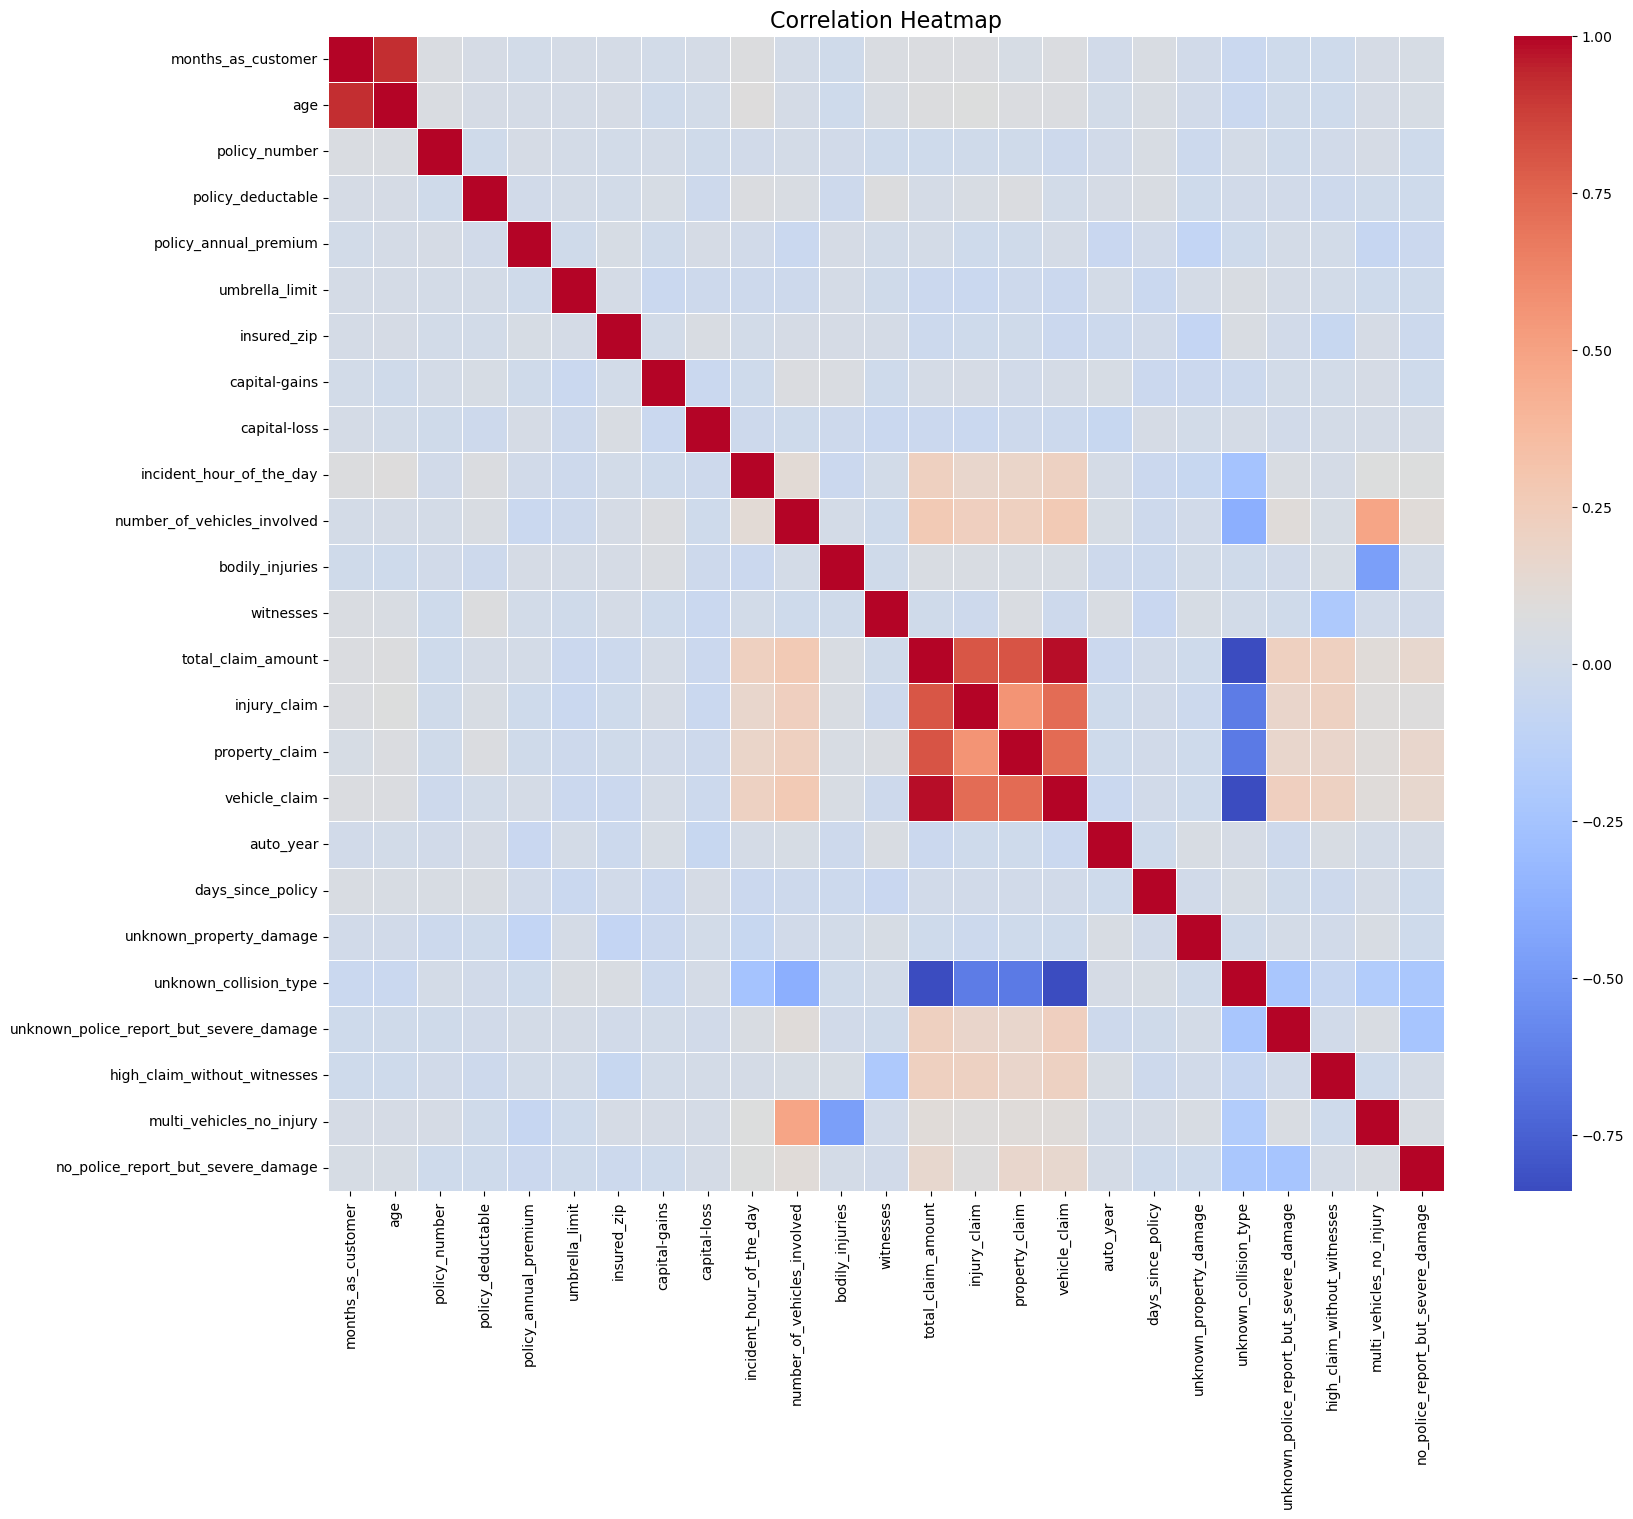

In [40]:
# heatmap setelah feature engineering

numeric_df = df.select_dtypes(include=np.number)
corr_matrix = numeric_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(18, 15))

# heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# Save Output

In [42]:

df.to_csv("D:\Kuliah\Semester 7\TA\Fraud_Insured_Automobile_Detection\data\df_feature_engineered.csv", index=False)

<>:1: SyntaxWarning: invalid escape sequence '\K'
<>:1: SyntaxWarning: invalid escape sequence '\K'
C:\Users\Wanda Azizah\AppData\Local\Temp\ipykernel_27716\603022201.py:1: SyntaxWarning: invalid escape sequence '\K'
  df.to_csv("D:\Kuliah\Semester 7\TA\Fraud_Insured_Automobile_Detection\data\df_feature_engineered.csv", index=False)
